In [ ]:
import lyricsgenius as Lg
from dotenv import load_dotenv
import os

load_dotenv()
genius = Lg.Genius(os.getenv("GENIUS_API_KEY"))

In [2]:
import re
import pandas as pd
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
bladee = genius.search_artist("Bladee")
all_lyrics = bladee.save_lyrics()

In [ ]:
# save as csv file
with open("Lyrics_Bladee.json", "r") as f:
    lyric_file = json.load(f)

# lyric filke is a dictionary, check keys
type(lyric_file)
lyric_file.keys()

In [ ]:
type(lyric_file["songs"])
song_data = lyric_file["songs"]

type(song_data[0])
song_data[0].keys()
song_data[0]['lyrics']

# data is a list with dictionaries, each song is a dictionary with a lyrics key

In [ ]:
# save all song lyrics into one csv file
song_lyrics = []

for iter in range(len(song_data)-1):
    song_lyrics.append(song_data[iter]['lyrics'])

file_path = "bladee_lyrics.csv"

with open(file_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for song in song_lyrics:
        writer.writerow([song])

In [ ]:
# save title, artist names, release date, and album name to another csv file
song_data[0].keys()

other_data = []

for i in range(len(song_data)-1):
    title = song_data[i].get('title',{})
    artist = song_data[i].get('artist_names',{})
    if song_data[i].get('album', None) is None:
        album = {}
    else:
        album = song_data[i].get('album',{}).get('name',{})
    release = song_data[i].get('release_date',{})

    arr = [title, artist, album, release]
    other_data.append(arr)

header = ['Title', 'Artist Names', 'Album', 'Release Date']

# saving to csv file
with open('songs_data.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(other_data)

In [3]:
# Clean lyrics file to be workable

# read in lyrics file
raw_data = pd.read_csv("bladee_lyrics.csv", header=None)
raw_data[['notes','intro']] = raw_data[0].str.split(r'(?=\[)', n=1, expand=True, regex=True)

# read in song information file
meta_data = pd.read_csv('songs_data.csv')
meta_data.insert(0, 'song_id', range(1, 323))

raw_data.index = meta_data['Title']
raw_data.drop(raw_data.columns[0], axis=1, inplace=True)

# this splits data where every column is  astructure of the song (as in verse, intro, outro, etc)
df_split = raw_data['intro'].str.split(r'(?=\[)', expand=True, regex=True)
df_split.drop(df_split.columns[0], axis=1, inplace=True)

# add a column for song_id to match with other data frame with song information
df_split.insert(0, 'song_id', range(1, 323))

# find all songs not a part of albums
no_album = []
for i in range(0,321):
    if meta_data.iloc[i].iloc[3] == '{}':
        no_album.append(meta_data.iloc[i].iloc[1])
        no_album.append(meta_data.iloc[i].iloc[0])

# selected which songs to remove from dataset that are duplicates of songs or not representative of Bladee
# able to do so due to my own personal familiarity to his music
delete_songid = [321, 316, 315, 314, 313, 312, 311, 310, 308, 307, 304, 301, 300, 291, 284, 283, 282, 275, 269]

meta_data_filtered = meta_data[~meta_data['song_id'].isin(delete_songid)]
meta_df = meta_data_filtered[~meta_data_filtered['Release Date'].isnull()] # remove if no release date

# get cleaned dataset using song id from cleaned meta_data
df_split_filtered = df_split[df_split['song_id'].isin(meta_df['song_id'])]

# rename columns for restructuring data set ease
df_filt_renamed = df_split_filtered.rename(columns={1:'part_1', 2:'part_2',
                                                    3:'part_3', 4:'part_4',
                                                    5:'part_5', 6:'part_6',
                                                    7:'part_7', 8:'part_8',
                                                    9:'part_9', 10:'part_10',
                                                    11:'part_11', 12:'part_12',
                                                    13:'part_13', 14:'part_14',
                                                    15:'part_15', 16:'part_16',
                                                    17:'part_17', 18:'part_18',
                                                    19:'part_19', 20:'part_20'})

# pivot longer so each row corresponds to one structure of music
longer_set = pd.wide_to_long(df_filt_renamed, i='song_id', stubnames='part', j='structure', sep='_').reset_index()
clean_longer = longer_set.dropna(subset=['part']).copy()
clean_longer[['struct_name', 'lyrics']] = clean_longer['part'].str.split(r'(?<=\])\s*', expand=True, regex=True)
clean_longer.drop(columns='part', inplace=True)

# pivopt longer to have each row correspond to one line of music with structure information
even_longer = clean_longer.assign(
    lyric_line=clean_longer['lyrics'].str.split(r'\r?\n')
).explode('lyric_line').reset_index(drop=True)
even_longer['line_num'] = even_longer.groupby(['song_id', 'structure', 'struct_name']).cumcount() + 1
df_long = even_longer[['song_id', 'structure', 'struct_name', 'line_num', 'lyric_line']]

# making sure the two data frames match
meta_df = meta_df[meta_df['song_id'].isin(df_long['song_id'])]

In [4]:
# Preprocess lyrics to put through SBERT
import contractions

def preprocess(lyrics):
    lyrics = lyrics.lower()
    lyrics = contractions.fix(lyrics)
    lyrics = re.sub(r'[^\w\s]', '', lyrics)
    lyrics = re.sub(r'\s+', ' ', lyrics).strip()
    return lyrics

df_long['cleaned_lyrics'] = df_long['lyric_line'].apply(preprocess)

In [5]:
from sentence_transformers import SentenceTransformer

# get word embeddings of each line
# could optimize this more
model = SentenceTransformer('all-MiniLM-L6-v2')
df_long['embedding'] = df_long['cleaned_lyrics'].apply(lambda x: model.encode(x))

Couldn't import dot_parser, loading of dot files will not be possible.


In [6]:
embedding_np = np.stack(df_long['embedding'].values)
train_set, val_set = embedding_np[:int(len(embedding_np)*0.8)], embedding_np[int(len(embedding_np)*0.8):]

I believe there to be 6 personas:
Evil Bladee,
Dark Bladee,
Romantic Bladee,
Flex Bladee,
Existential Bladee,
Party Bladee

**This may not be optimal, just a educated guess as a longtime fan of Bladee

In [7]:
# Archetypal Analysis Approximation through NMF
from sklearn.decomposition import NMF
from scipy.optimize import nnls

X_min = embedding_np.min()

# standardize sets to ensure non-negativity
train_set2 = train_set.copy()
train_set2 -= X_min

val_set2 = val_set.copy()
val_set2 -= X_min

full_set = embedding_np - X_min

# helper function to calculate validation loss
def calculate_val_loss(val_set, h):
    val_loss = []

    for i in range(val_set.shape[0]):
        x = val_set[i]
        w, _ = nnls(h.T, x)
        x_hat = w @ h
        loss = np.linalg.norm(x - x_hat)
        val_loss.append(loss)
    
    return np.mean(val_loss)

# function to perform NMF
def nmf_aa(train_set, val_set, n_components, max_iter=10000):
    nmf = NMF(n_components=n_components, max_iter=max_iter, random_state=42)
    W = nmf.fit_transform(train_set)
    H = nmf.components_

    val_loss = calculate_val_loss(val_set, H)

    return W, H, val_loss

In [8]:
# Get archetypes for entire dataset based on trained components
W, H, val_loss = nmf_aa(train_set2, val_set2, 7)

W_new = []
for x in full_set:
    w, _ = nnls(H.T, x)
    W_new.append(w)

archetype_assignments = np.array(W_new).argmax(axis=1)

In [9]:
# add archetypes to full dataframe
df_approx = df_long.copy()
df_approx['archetype'] = archetype_assignments
df_approx

,song_id,structure,struct_name,line_num,lyric_line,cleaned_lyrics,embedding,archetype
0,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",1,Drain Gang forever,drain gang forever,"[-0.06626457, 0.022468945, 0.0038471026, 0.009...",3
1,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",2,"So, guess what?",so guess what,"[-0.010658534, -0.05710398, -0.011820533, -0.0...",2
2,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",3,What? I don't know,what i do not know,"[-0.015976546, 0.022221526, -0.09358572, -0.03...",2
3,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",4,"Take a knife and drain your life (Uh, uh, uh)",take a knife and drain your life uh uh uh,"[0.0032876763, 0.049389165, 0.051779177, 0.046...",2
4,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",5,,,"[-0.11883848, 0.04829867, -0.002548106, -0.011...",5
...,...,...,...,...,...,...,...,...
12791,23,20,[Outro: Ecco2k],3,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...",2
12792,23,20,[Outro: Ecco2k],4,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...",2
12793,23,20,[Outro: Ecco2k],5,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...",2
12794,23,20,[Outro: Ecco2k],6,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...",2


In [10]:
# frequency of each archetype in a song

nmf_freq = (
    df_approx.groupby('song_id')['archetype']
    .value_counts()
    .unstack(fill_value=0)
)

nmf_freq = round(nmf_freq.div(nmf_freq.sum(axis=1), axis=0), 4)
nmf_freq['a_max'] = nmf_freq.idxmax(axis=1)
nmf_freq

archetype,1,2,3,4,5,6,a_max
song_id,,,,,,,
1,0.0000,0.5870,0.1304,0.0217,0.1957,0.0652,2
2,0.0769,0.3385,0.1692,0.0769,0.1231,0.2154,2
3,0.0444,0.0667,0.2889,0.2444,0.2000,0.1556,3
4,0.0698,0.3256,0.1163,0.1395,0.2093,0.1395,2
5,0.0784,0.3137,0.1569,0.0588,0.2549,0.1373,2
...,...,...,...,...,...,...,...
295,0.0000,0.0000,0.0000,0.3333,0.3333,0.3333,4
299,0.0465,0.2093,0.0000,0.3256,0.2558,0.1628,4
303,0.0000,0.0000,0.0000,0.8000,0.2000,0.0000,4


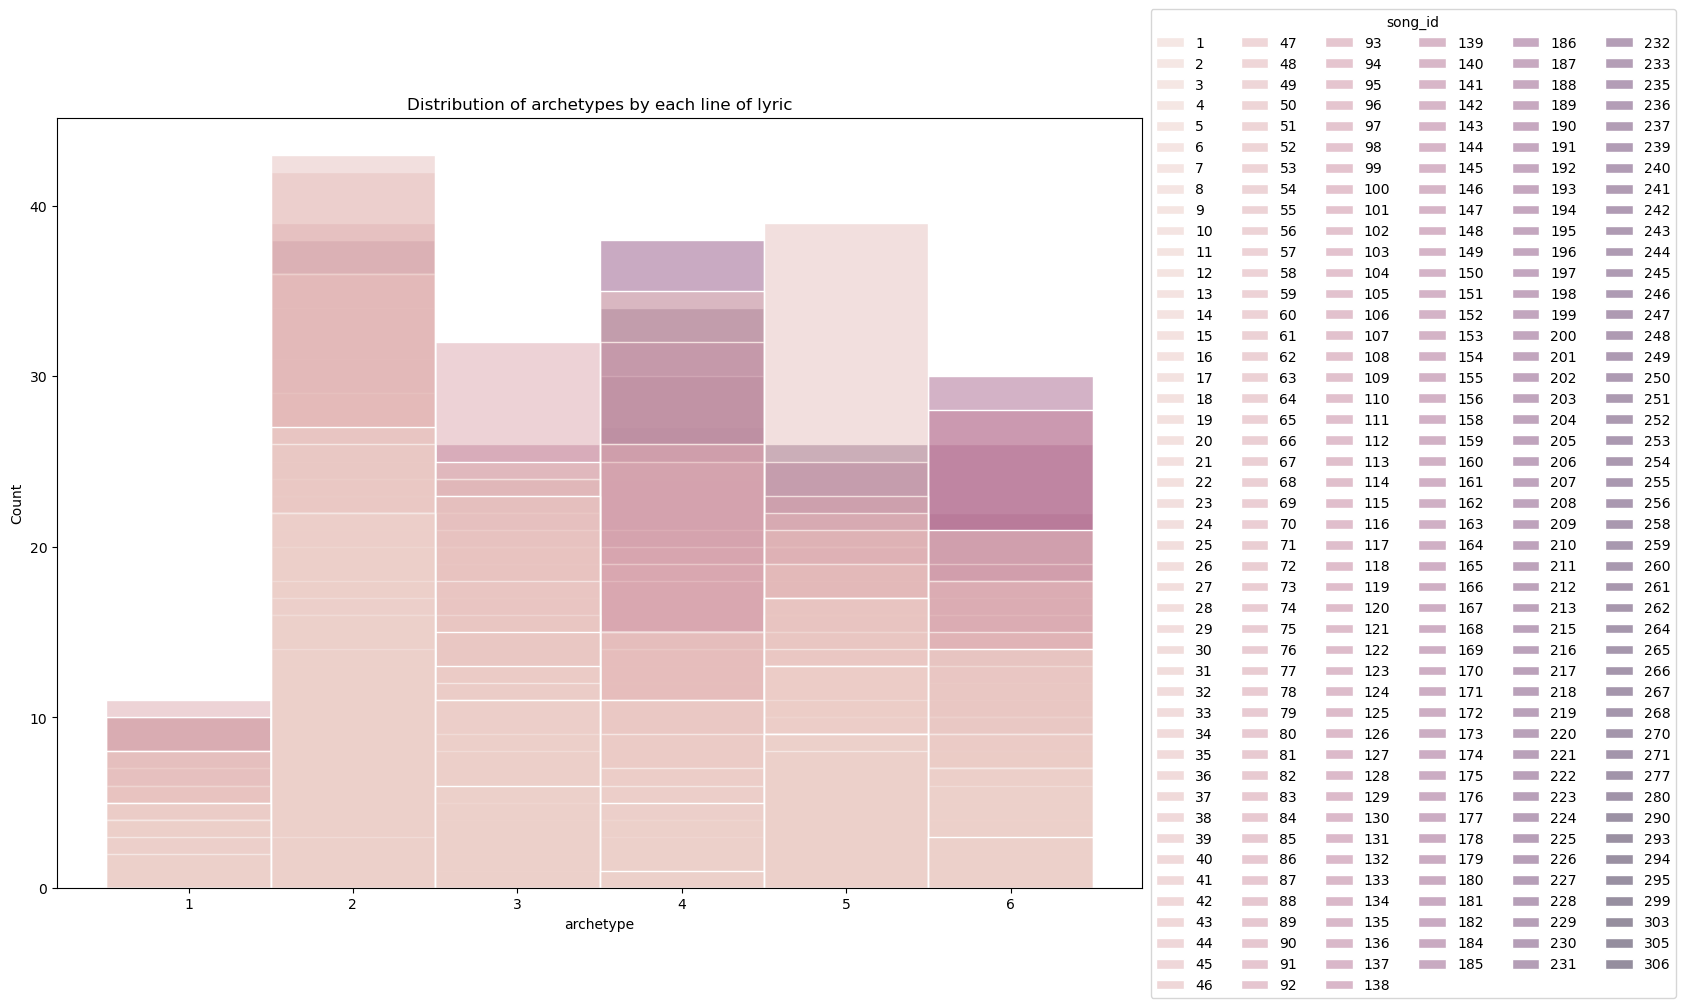

In [11]:
# distribution of archetypes by line
plt.figure(figsize=(14,10))
ax = sns.histplot(data=df_approx, x="archetype", hue='song_id', discrete=True, edgecolor="1")
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(1.25, 1.15), ncol=6)
plt.title("Distribution of archetypes by each line of lyric")
plt.show()

In [12]:
# prepare dataframe for better visualization

nmf_archetype = meta_df.copy()
nmf_archetype.set_index('song_id', inplace=True)
nmf_archetype['NMF_Archetype'] = nmf_freq['a_max']

nmf_archetype['Release Date'] = pd.to_datetime(nmf_archetype['Release Date'])
nmf_archetype['Year'] = nmf_archetype['Release Date'].dt.year
nmf_archetype['Month'] = nmf_archetype['Release Date'].dt.month

In [13]:
nmf_archetype["Artist Names"].unique()

def clean_features(df):
    main = 'Bladee'
    df = df.replace(main, '').strip()

    # get featured artists
    ft = re.findall(r'\(Ft\. (.*?)\)', df)
    df = re.sub(r'\(Ft\. .*?\)', '', df).strip()

    others = re.split(r'[,&]', df)
    others = [o.strip() for o in others if o.strip()]

    features = []
    if ft:
        features += re.split(r'[,&]', ft[0])
    features += others
    features = [f for f in features if f != '' and f != main]  # Remove empty & 'Bladee'
    features = sorted(set(features))  # Unique & sorted

    return f"{main} (feat. {', '.join(features)})" if features else main

nmf_archetype['Artist Names'] = nmf_archetype['Artist Names'].apply(clean_features)

nmf_archetype

,Title,Artist Names,Album,Release Date,NMF_Archetype,Year,Month
song_id,,,,,,,
1,Be Nice 2 Me,Bladee,Icedancer,2018-12-29,2,2018,12
2,Obedient,Bladee (feat. Ecco2k),Red Light,2018-05-11,2,2018,5
3,Western Union,"Bladee (feat. Ecco2k, Thaiboy Digital)",Trash Island,2019-09-12,3,2019,9
4,Hotel Breakfast,Bladee,The Fool,2021-05-28,2,2021,5
5,Plastic Surgery,Bladee (feat. Ecco2k),Plastic Surgery,2017-04-28,2,2017,4
...,...,...,...,...,...,...,...
295,​Tofu Golem,Bladee,{},2013-05-01,4,2013,5
299,God (Evian Christ Remix),Bladee (feat. Mechatok),Good Luck (Deluxe),2021-03-26,4,2021,3
303,Grace (Salem Remix),Bladee (feat. Mechatok),Good Luck (Deluxe),2021-04-09,4,2021,4


Text(0.5, 1.0, 'Archetypes by album (albums ordered by release date)')

<Figure size 1600x1000 with 0 Axes>

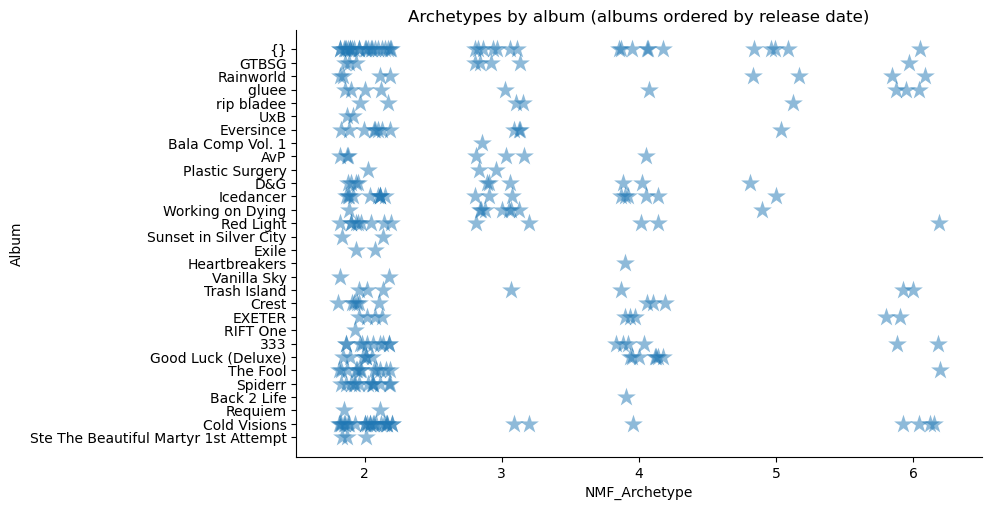

In [ ]:
nmf_sorted = nmf_archetype.sort_values(by="Release Date")
nmf_sorted['NMF_Archetype'] = nmf_sorted['NMF_Archetype'].astype('category')

plt.figure(figsize=(16, 10))
ax = sns.catplot(data=nmf_sorted, x="NMF_Archetype", y="Album", 
                 aspect=2, marker='*', s=200, alpha=0.5, jitter=0.2)
plt.title("Archetypes by album (albums ordered by release date)")

Text(0.5, 1.0, 'Archetypes over time (Featured Artists)')

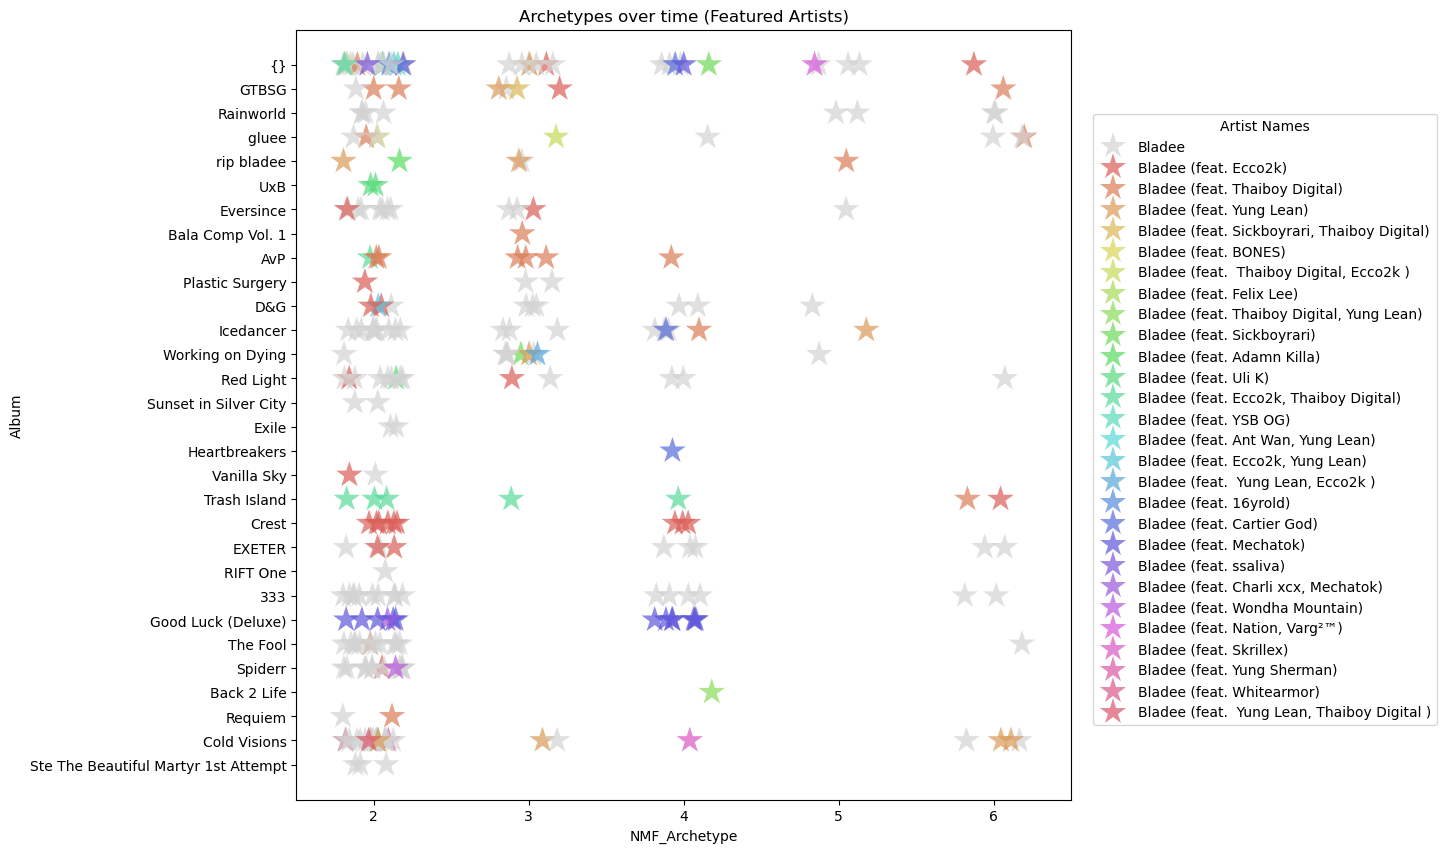

In [108]:
pal = ['lightgray'] + sns.color_palette("hls", 27)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.stripplot(data=nmf_sorted, y="Album", x="NMF_Archetype", hue='Artist Names', ax=ax,
                   s=20, marker='*', jitter=0.2, palette=pal, alpha=0.7)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(1.25, 0.9))
plt.title("Archetypes over time (Featured Artists)")

Text(0.5, 1.0, 'Density of Archeype Weights per line')

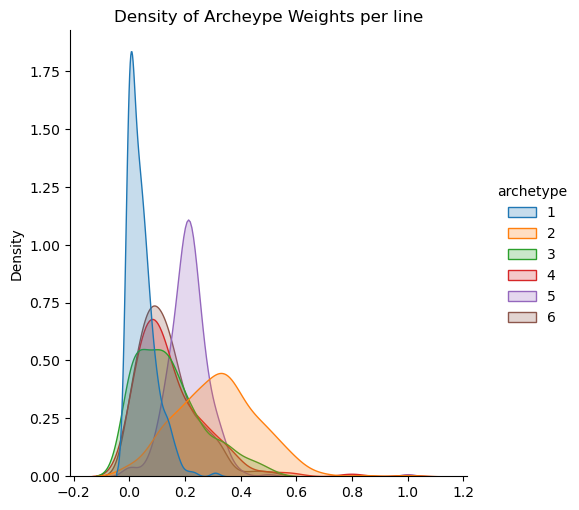

In [134]:
nmf_f = nmf_freq.iloc[:, :-1]
sns.displot(data=nmf_f, kind='kde', fill=True)
plt.title("Density of Archeype Weights per line")

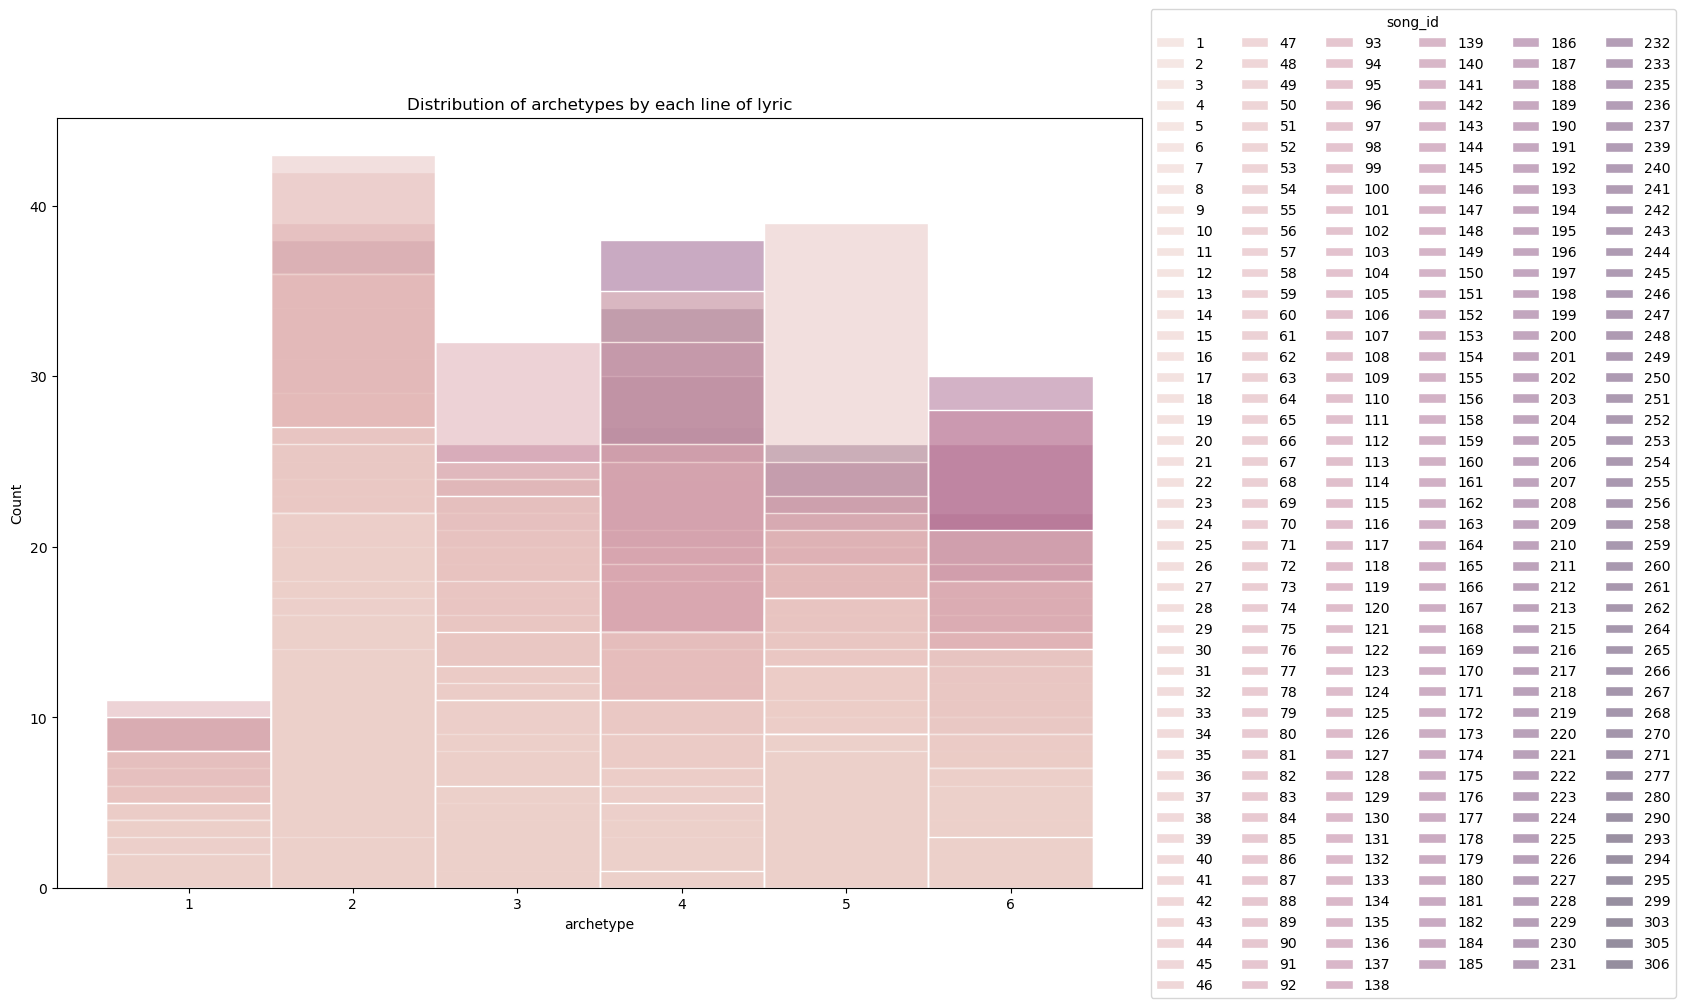

In [133]:
# distribution of archetypes by line
plt.figure(figsize=(14,10))
ax = sns.histplot(data=df_approx, x="archetype", hue='song_id', discrete=True, edgecolor="1")
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(1.25, 1.15), ncol=6)
plt.title("Distribution of archetypes by each line of lyric")
plt.show()

In [135]:
# AA as an Autoencoder (Deep Archetypal Analysis)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class ArchAutoencoder(nn.Module):
    def __init__(self, input_dim, n_archetypes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, n_archetypes)
        )

        self.archetypes = nn.Parameter(torch.randn(n_archetypes, input_dim))
    
    def forward(self, x):
        z = self.encoder(x)
        w = F.softmax(z, dim = 1)
        embeddings = w @ self.archetypes
        return embeddings, w

In [136]:
# initialize
epochs = 50
batch_size = (32, 64)
train_tensor = torch.tensor(train_set, dtype=torch.float32)
val_tensor = torch.tensor(val_set, dtype=torch.float32)
input_dim = embedding_np.shape[1]
n_arch = 6

In [137]:
model = ArchAutoencoder(input_dim=input_dim, n_archetypes=n_arch)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_dataset, val_dataset = TensorDataset(train_tensor), TensorDataset(val_tensor)

for batch in batch_size:
    # data to tensors + dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # track train loss
    train_loss_history = []
    val_loss_history = []
    best_loss = float('inf')
    best_batch = 0

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0

        for b in train_loader:
            x_batch = b[0].to(device)

            # forward pass
            embed_pred, w = model(x_batch)

            # loss calculation
            loss = 1 - F.cosine_similarity(embed_pred, x_batch, dim=1).mean()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_total_loss += loss.item()
    
        model.eval()
        val_total_loss = 0

        with torch.no_grad():
            for b in val_loader:
                x_batch = b[0].to(device)
                embed_pred, w = model(x_batch)

                loss = 1 - F.cosine_similarity(embed_pred, x_batch, dim=1).mean()
                val_total_loss += loss.item()

        # epoch loss
        train_epoch_loss = train_total_loss / len(train_loader)
        val_epoch_loss = val_total_loss / len(val_loader)
        train_loss_history.append(train_epoch_loss)
        val_loss_history.append(val_epoch_loss)
        
        print(f"Epoch {epoch} and Batch {batch}: Train Loss = {train_epoch_loss:.4f}, Val Loss = {val_epoch_loss:.4f}")

        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_batch = batch
            torch.save(model.state_dict(), 'best_model.pth')
print(f"Best Batch: {best_batch}, Val_Loss: {best_loss}")

Epoch 0 and Batch 32: Train Loss = 0.9051, Val Loss = 0.8326
Epoch 1 and Batch 32: Train Loss = 0.7657, Val Loss = 0.7160
Epoch 2 and Batch 32: Train Loss = 0.6611, Val Loss = 0.6319
Epoch 3 and Batch 32: Train Loss = 0.5926, Val Loss = 0.5828
Epoch 4 and Batch 32: Train Loss = 0.5533, Val Loss = 0.5556
Epoch 5 and Batch 32: Train Loss = 0.5286, Val Loss = 0.5364
Epoch 6 and Batch 32: Train Loss = 0.5101, Val Loss = 0.5231
Epoch 7 and Batch 32: Train Loss = 0.4978, Val Loss = 0.5144
Epoch 8 and Batch 32: Train Loss = 0.4896, Val Loss = 0.5087
Epoch 9 and Batch 32: Train Loss = 0.4841, Val Loss = 0.5045
Epoch 10 and Batch 32: Train Loss = 0.4801, Val Loss = 0.5012
Epoch 11 and Batch 32: Train Loss = 0.4770, Val Loss = 0.4986
Epoch 12 and Batch 32: Train Loss = 0.4744, Val Loss = 0.4964
Epoch 13 and Batch 32: Train Loss = 0.4723, Val Loss = 0.4945
Epoch 14 and Batch 32: Train Loss = 0.4705, Val Loss = 0.4928
Epoch 15 and Batch 32: Train Loss = 0.4688, Val Loss = 0.4911
Epoch 16 and Batch

Tried 128 batch size and the val loss did go lower, but does not meaningfully go lower so using a batch size of 64

In [138]:
# get archetypes
full_set_tensor = torch.tensor(embedding_np, dtype=torch.float32)
tensor_embeddings = TensorDataset(full_set_tensor)
loader = DataLoader(tensor_embeddings, batch_size=best_batch, shuffle=False)

model = ArchAutoencoder(input_dim=input_dim, n_archetypes=n_arch)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

arch_vectors = model.archetypes.data.cpu().numpy()

all_weights = []
with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(device)
        _, w = model(x_batch)
        all_weights.append(w.cpu().numpy())
np_allWeights = np.vstack(all_weights)
dom_archetype = np.argmax(np_allWeights, axis=1)

In [139]:
autoen_archetypes = df_long.copy()
autoen_archetypes['a_weights'] = list(np_allWeights)
autoen_archetypes['archetype'] = dom_archetype
autoen_archetypes

,song_id,structure,struct_name,line_num,lyric_line,cleaned_lyrics,embedding,a_weights,archetype
0,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",1,Drain Gang forever,drain gang forever,"[-0.06626457, 0.022468945, 0.0038471026, 0.009...","[0.007830133, 0.2336215, 0.17548509, 0.2951923...",3
1,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",2,"So, guess what?",so guess what,"[-0.010658534, -0.05710398, -0.011820533, -0.0...","[0.17497209, 0.12702486, 0.14130759, 0.2058557...",4
2,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",3,What? I don't know,what i do not know,"[-0.015976546, 0.022221526, -0.09358572, -0.03...","[0.20219149, 0.15490437, 0.13709082, 0.1735120...",0
3,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",4,"Take a knife and drain your life (Uh, uh, uh)",take a knife and drain your life uh uh uh,"[0.0032876763, 0.049389165, 0.051779177, 0.046...","[0.1615789, 0.18052888, 0.21405521, 0.18086463...",2
4,1,1,"[Intro: Bladee, Elliot Page & Michael Cera]",5,,,"[-0.11883848, 0.04829867, -0.002548106, -0.011...","[0.25250325, 0.036559187, 0.10295555, 0.227084...",4
...,...,...,...,...,...,...,...,...,...
12791,23,20,[Outro: Ecco2k],3,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...","[0.16727632, 0.08372126, 0.14417087, 0.1856123...",4
12792,23,20,[Outro: Ecco2k],4,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...","[0.16727632, 0.08372126, 0.14417087, 0.1856123...",4
12793,23,20,[Outro: Ecco2k],5,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...","[0.16727632, 0.08372126, 0.14417087, 0.1856123...",4
12794,23,20,[Outro: Ecco2k],6,I love you,i love you,"[-0.109195426, 0.080210164, 0.068806164, -0.06...","[0.16727632, 0.08372126, 0.14417087, 0.1856123...",4


In [140]:
# frequency of each archetype in a song

ae_freq = (
    autoen_archetypes.groupby('song_id')['archetype']
    .value_counts()
    .unstack(fill_value=0)
)

ae_freq = round(ae_freq.div(ae_freq.sum(axis=1), axis=0), 4)
ae_freq.rename(columns = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}, inplace=True)
ae_freq['a_max'] = ae_freq.idxmax(axis=1)
ae_freq

archetype,1,2,3,4,5,6,a_max
song_id,,,,,,,
1,0.1739,0.0435,0.1087,0.1957,0.3043,0.1739,5
2,0.1385,0.1538,0.1692,0.1538,0.2923,0.0923,5
3,0.1556,0.0889,0.0889,0.2000,0.3778,0.0889,5
4,0.1628,0.0233,0.0930,0.2558,0.3721,0.0930,5
5,0.0980,0.0980,0.2549,0.1373,0.2549,0.1569,3
...,...,...,...,...,...,...,...
295,0.0000,0.0000,0.0000,0.3333,0.6667,0.0000,5
299,0.0698,0.0233,0.0000,0.0233,0.6512,0.2326,5
303,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,5


In [141]:
# compare archetypes from autoencoder with nmf
ae_df = nmf_archetype.copy()
ae_df['AE_Archetype'] = ae_freq['a_max']
ae_df

,Title,Artist Names,Album,Release Date,NMF_Archetype,Year,Month,AE_Archetype
song_id,,,,,,,,
1,Be Nice 2 Me,Bladee,Icedancer,2018-12-29,2,2018,12,5
2,Obedient,Bladee (feat. Ecco2k),Red Light,2018-05-11,2,2018,5,5
3,Western Union,"Bladee (feat. Ecco2k, Thaiboy Digital)",Trash Island,2019-09-12,3,2019,9,5
4,Hotel Breakfast,Bladee,The Fool,2021-05-28,2,2021,5,5
5,Plastic Surgery,Bladee (feat. Ecco2k),Plastic Surgery,2017-04-28,2,2017,4,3
...,...,...,...,...,...,...,...,...
295,​Tofu Golem,Bladee,{},2013-05-01,4,2013,5,5
299,God (Evian Christ Remix),Bladee (feat. Mechatok),Good Luck (Deluxe),2021-03-26,4,2021,3,5
303,Grace (Salem Remix),Bladee (feat. Mechatok),Good Luck (Deluxe),2021-04-09,4,2021,4,5


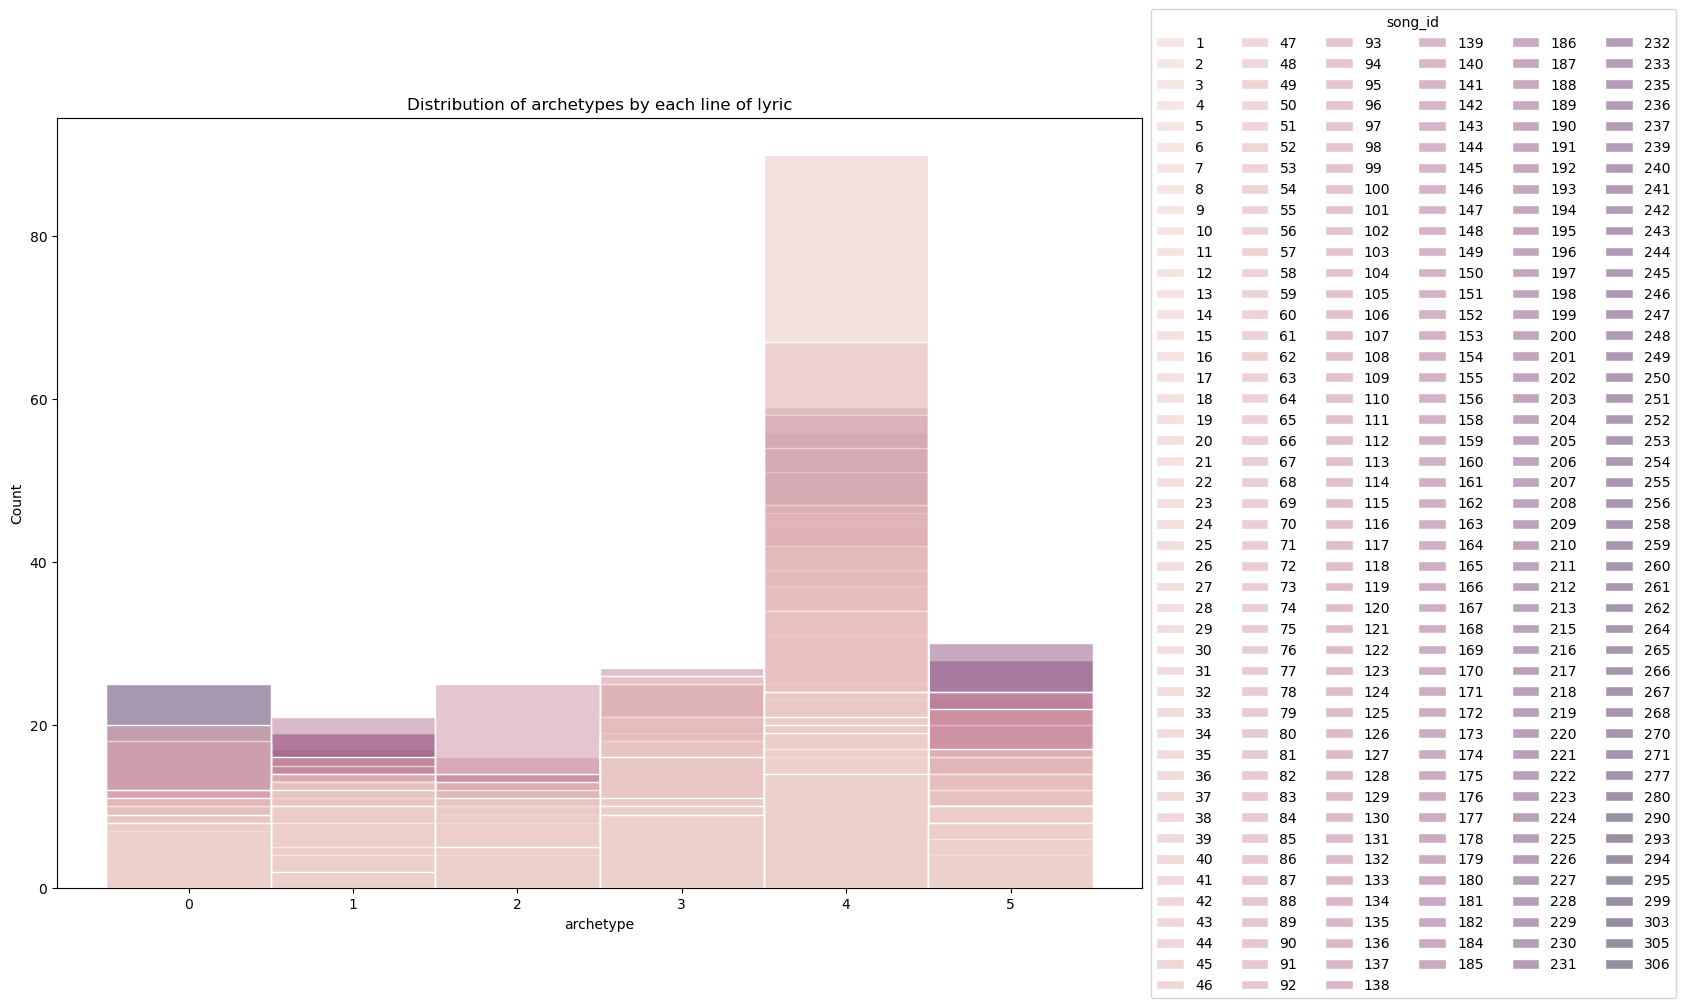

In [142]:
# distribution of archetypes by line
plt.figure(figsize=(14,10))
ax = sns.histplot(data=autoen_archetypes, x="archetype", hue='song_id', discrete=True, edgecolor="1")
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(1.25, 1.15), ncol=6)
plt.title("Distribution of archetypes by each line of lyric")
plt.show()

Text(0.5, 1.0, 'Archetypes by album (albums ordered by release date)')

<Figure size 1600x1000 with 0 Axes>

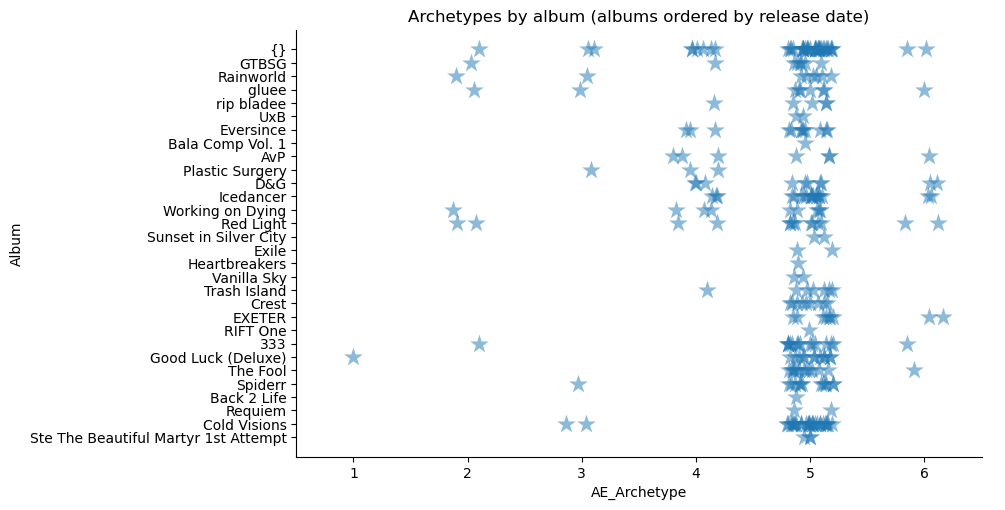

In [143]:
ae_sorted = ae_df.sort_values(by="Release Date")
ae_sorted['AE_Archetype'] = ae_sorted['AE_Archetype'].astype('category')

plt.figure(figsize=(16, 10))
ax = sns.catplot(data=ae_sorted, x="AE_Archetype", y="Album", 
                 aspect=2, marker='*', s=200, alpha=0.5, jitter=0.2)
plt.title("Archetypes by album (albums ordered by release date)")

Text(0.5, 1.0, 'Archetypes across albums (Featured Artists)')

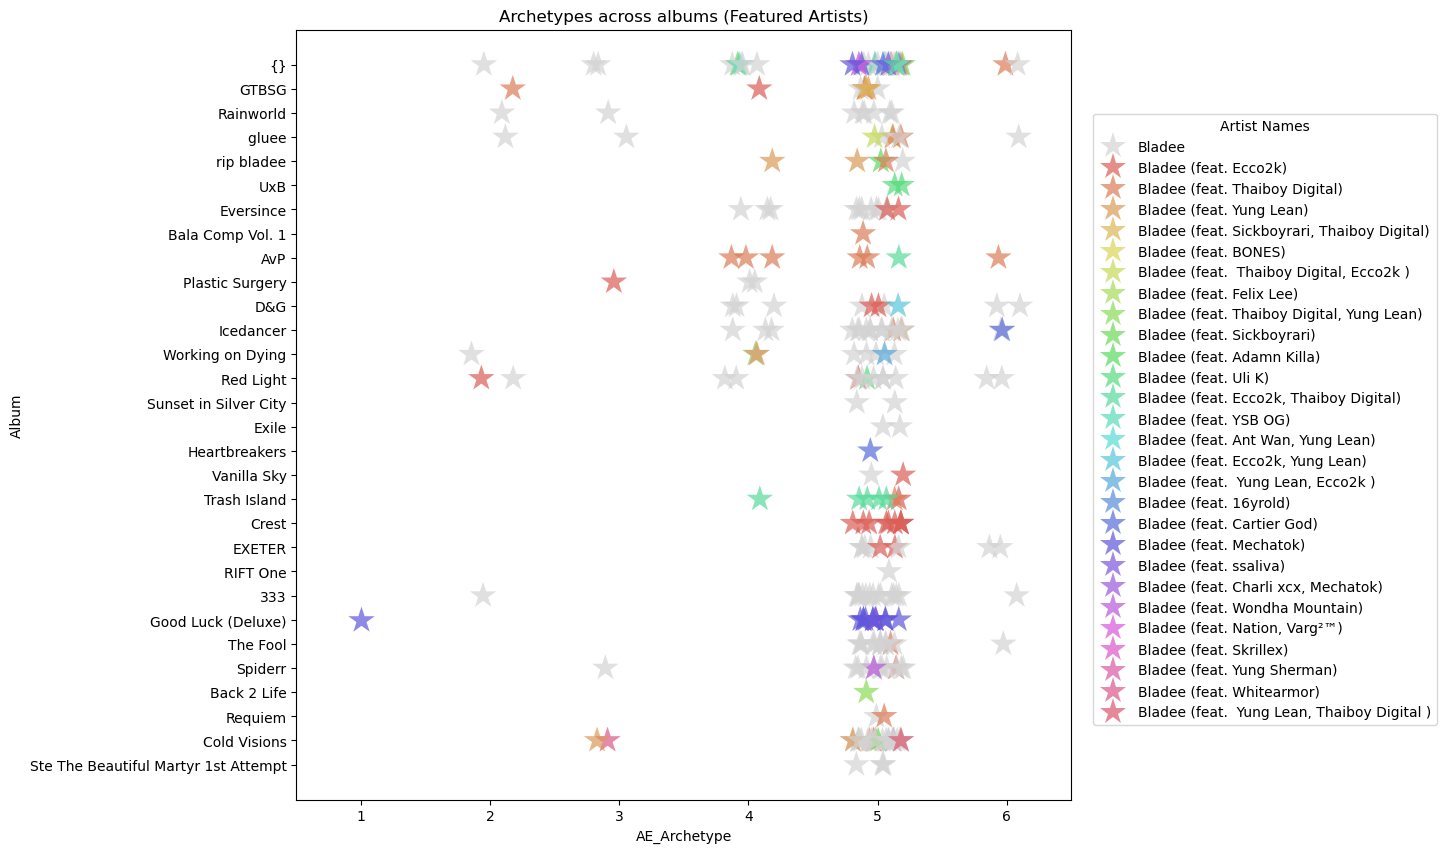

In [146]:
pal = ['lightgray'] + sns.color_palette("hls", 27)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.stripplot(data=ae_sorted, y="Album", x="AE_Archetype", hue='Artist Names', ax=ax,
                   s=20, marker='*', jitter=0.2, palette=pal, alpha=0.7)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(1.25, 0.9))
plt.title("Archetypes across albums (Featured Artists)")

In [152]:
# reset index and makign song_id a column
ae_sorted['song_id'] = ae_sorted.index
ae_sorted.reset_index(drop=True, inplace=True)
ae_sorted

,Title,Artist Names,Album,Release Date,NMF_Archetype,Year,Month,AE_Archetype,song_id
0,Always High,Bladee,{},2011-08-06,2,2011,8,5,252
1,Tony Hawk,Bladee (feat. Ecco2k),{},2011-08-29,3,2011,8,5,176
2,Smoke In My Eyes,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-01,6,2013,4,2,258
3,Carwash,Bladee,GTBSG,2013-04-16,3,2013,4,5,149
4,Im Lost,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-23,2,2013,4,5,226
...,...,...,...,...,...,...,...,...,...
268,LUCKY LUKE,"Bladee (feat. Yung Lean, Thaiboy Digital )",Cold Visions,2024-04-24,2,2024,4,5,130
269,Glädjeklockor.mp4,Bladee (feat. Mechatok),{},2025-02-09,4,2025,2,5,294
270,St George The Martyr,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2,2025,4,5,261
271,One In A Million,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2,2025,4,5,213


In [153]:
# Comparing NMF and AE
merged_df = ae_sorted.melt(
    id_vars = ['Title', 'Artist Names', 'Album', 'Release Date','Year','Month', 'song_id'],
    value_vars=['AE_Archetype', 'NMF_Archetype'],
    var_name='Method',
    value_name='Archetype')

#merged_df = merged_df.sort_values(by="song_id")
merged_df

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
0,Always High,Bladee,{},2011-08-06,2011,8,252,AE_Archetype,5
1,Tony Hawk,Bladee (feat. Ecco2k),{},2011-08-29,2011,8,176,AE_Archetype,5
2,Smoke In My Eyes,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-01,2013,4,258,AE_Archetype,2
3,Carwash,Bladee,GTBSG,2013-04-16,2013,4,149,AE_Archetype,5
4,Im Lost,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-23,2013,4,226,AE_Archetype,5
...,...,...,...,...,...,...,...,...,...
541,LUCKY LUKE,"Bladee (feat. Yung Lean, Thaiboy Digital )",Cold Visions,2024-04-24,2024,4,130,NMF_Archetype,2
542,Glädjeklockor.mp4,Bladee (feat. Mechatok),{},2025-02-09,2025,2,294,NMF_Archetype,4
543,St George The Martyr,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2025,4,261,NMF_Archetype,2
544,One In A Million,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2025,4,213,NMF_Archetype,2


<Figure size 1400x1800 with 0 Axes>

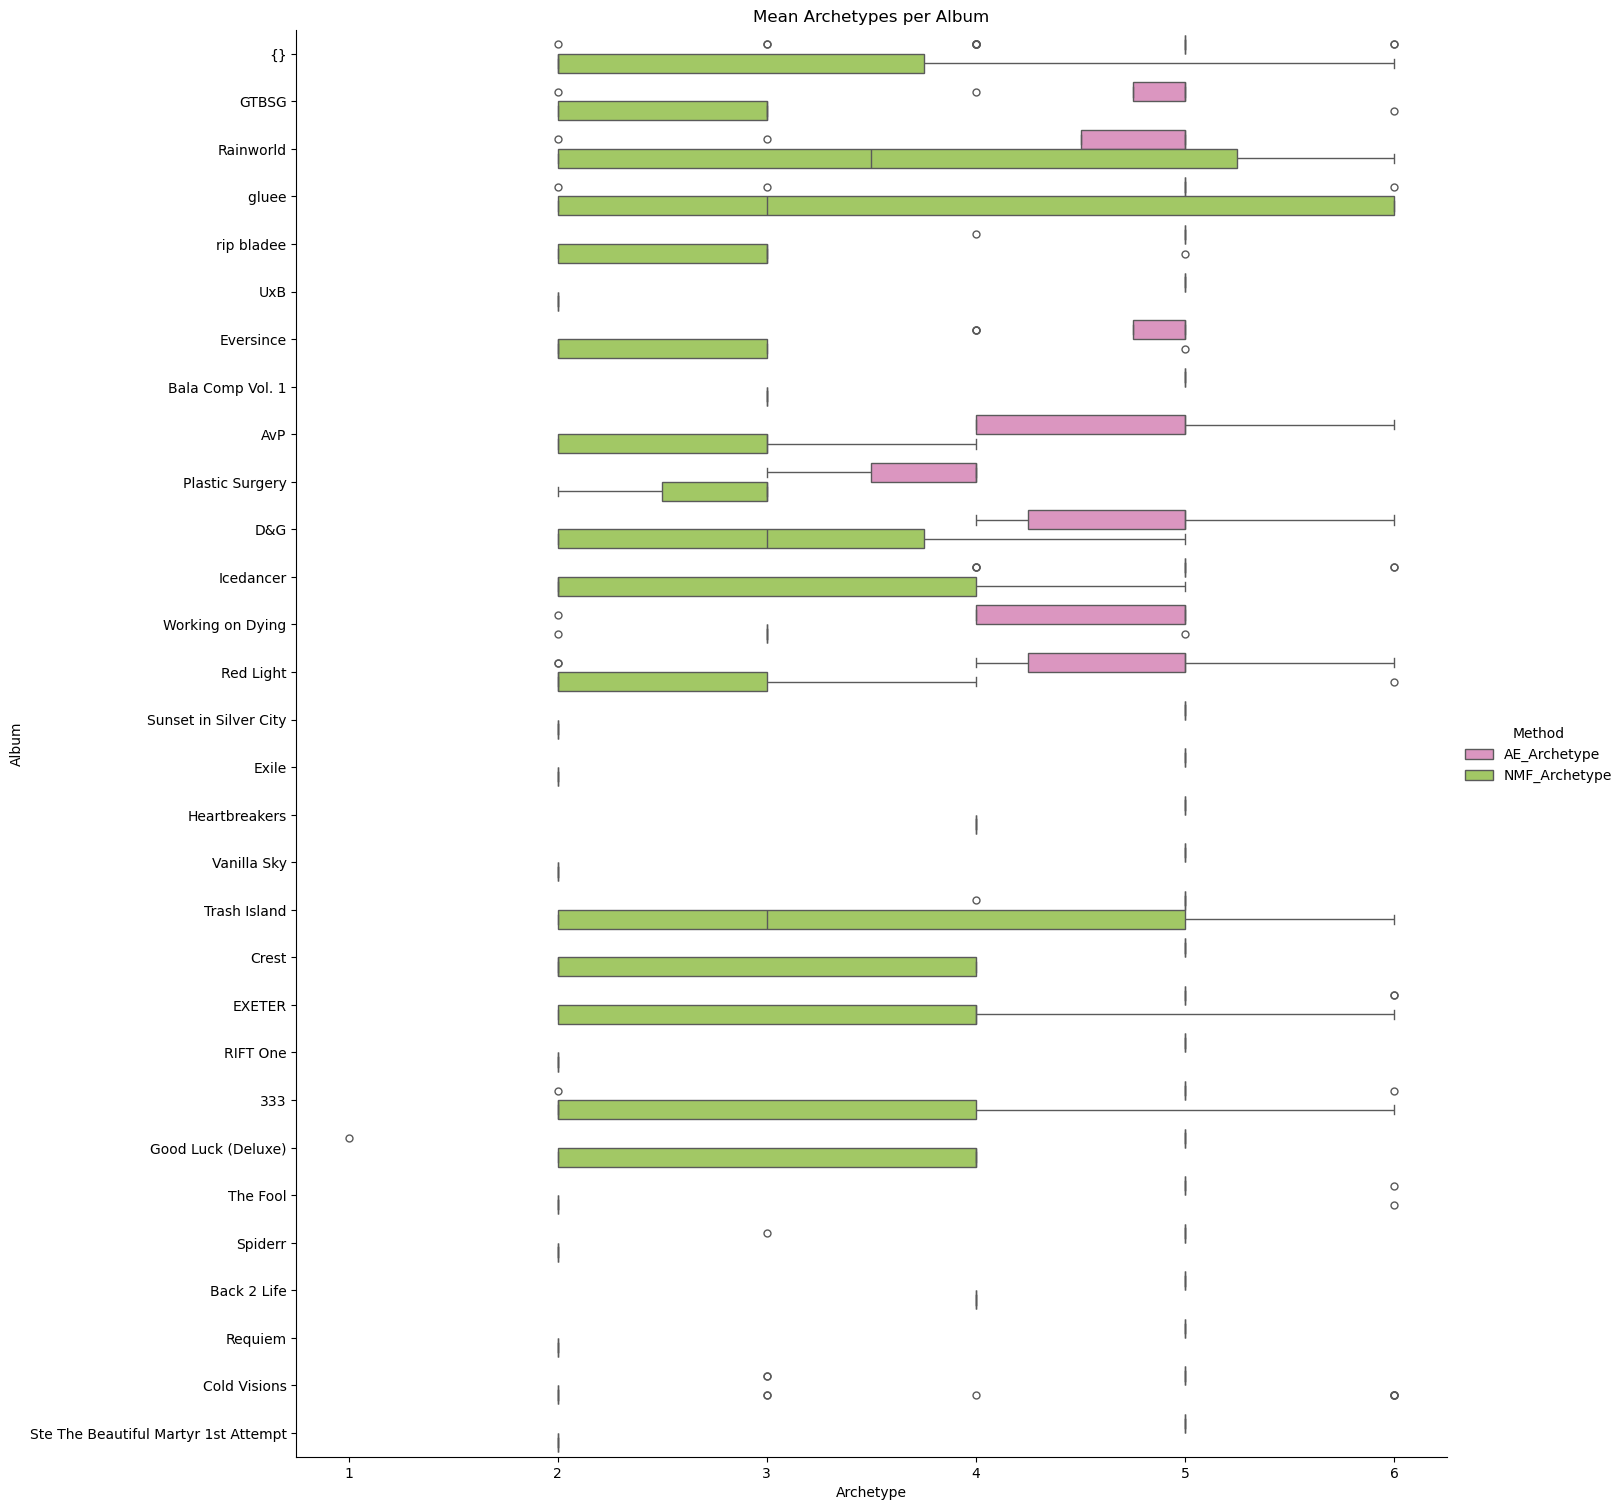

In [154]:
plt.figure(figsize=(14,18))
pal = sns.color_palette("Set2")[3:5]
alb = sns.catplot(kind='box', data=merged_df, y="Album", x="Archetype", hue="Method", aspect=1, height=15, palette=pal)
plt.title("Mean Archetypes per Album")
plt.savefig('boxcomaprison_byalbum.png')
plt.show()

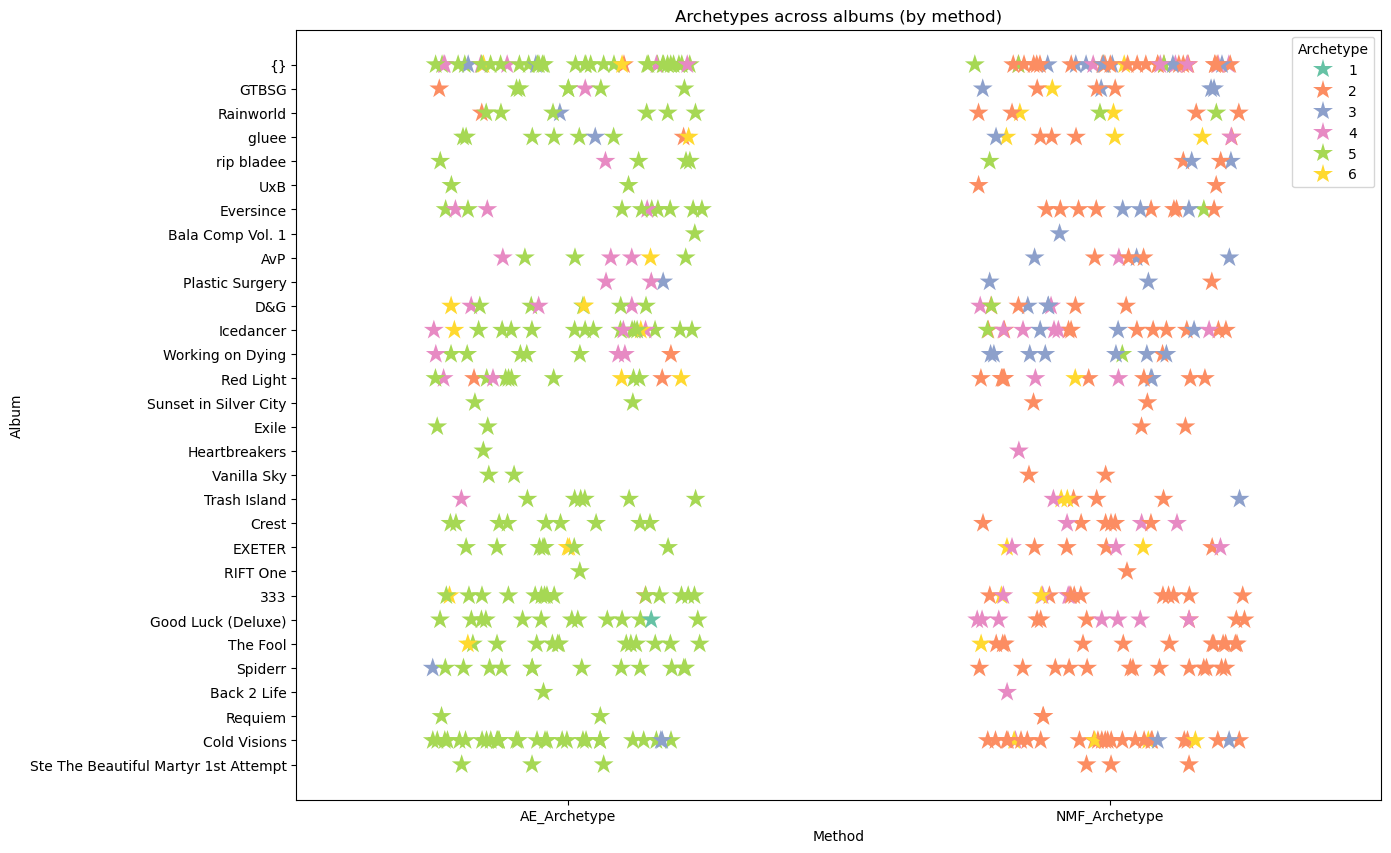

In [172]:
plt.figure(figsize=(14,10))
sns.stripplot(data=merged_df, x="Method", y="Album", hue='Archetype', 
                   palette='Set2', jitter=0.25, marker='*', s=15)
plt.title("Archetypes across albums (by method)")
plt.show()

The two different methods seem to vary quite a bit. No general trend of a change in archetypes as time goes on, but widest spread of archetypes seem to have occurred from 2012-2017. 

Evil Bladee,
Dark Bladee,
Romantic Bladee,
Flex Bladee,
Existential Bladee,
Party Bladee

In [173]:
merged_df[merged_df['Archetype'] == 1] # Only the Autoencoder has Archetype 1

## Songs like Plastic Surgery, Wrist Cry, Romeo, Wings in Motion, Dark Bladee

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
190,Into One,Bladee (feat. Mechatok),Good Luck (Deluxe),2020-12-10,2020,12,260,AE_Archetype,1


In [174]:
nmf_df = merged_df[merged_df['Method'] == 'NMF_Archetype']
nmf_df[nmf_df['Archetype'] == 2] # Classic Bladee
## Be nice 2 Me, Obedient, Hotel Breakfast, I'm Goofy, seems to be a mixed bag

ae_df = merged_df[merged_df['Method'] == 'AE_Archetype']
ae_df[ae_df['Archetype'] == 2] # Flex Bladee
# Western union, Mallwhore Freestyle, Trash Star, D-925, spellbound

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
2,Smoke In My Eyes,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-01,2013,4,258,AE_Archetype,2
12,​chainsaw,Bladee,{},2013-07-22,2013,7,262,AE_Archetype,2
15,crushed,Bladee,Rainworld,2013-10-01,2013,10,241,AE_Archetype,2
20,​upgrade enabled,Bladee,‌gluee,2014-01-20,2014,1,219,AE_Archetype,2
97,D-925,Bladee,Working on Dying,2017-12-28,2017,12,99,AE_Archetype,2
106,For You,Bladee (feat. Ecco2k),Red Light,2018-05-11,2018,5,22,AE_Archetype,2
115,Westfield,Bladee,Red Light,2018-05-11,2018,5,66,AE_Archetype,2
175,Wings in Motion,Bladee,333,2020-07-16,2020,7,125,AE_Archetype,2


In [175]:
nmf_df[nmf_df['Archetype'] == 3] # Flex Bladee
## Mixed, but has Western union, Mallwhore Freestyle, Trash Star, Chery Bracelets, Decay, Gatekeeper, Under you spell

ae_df[ae_df['Archetype'] == 3] # Existential Bladee
## Who Goes There, the Flag is Raised, Vanilla Sky, Side by Side, WetWater333, Grace, Crest Whimsical

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
19,Jewelry,Bladee,{},2014-01-15,2014,1,144,AE_Archetype,3
24,Unreal,Bladee,‌gluee,2014-01-20,2014,1,31,AE_Archetype,3
30,Into Dust,Bladee,Rainworld,2014-08-05,2014,8,17,AE_Archetype,3
46,Cold,Bladee,{},2015-11-20,2015,11,293,AE_Archetype,3
75,Plastic Surgery,Bladee (feat. Ecco2k),Plastic Surgery,2017-04-28,2017,4,5,AE_Archetype,3
224,ITS OK TO NOT BE OK,Bladee,Spiderr,2022-09-30,2022,9,242,AE_Archetype,3
247,I DONT LIKE PEOPLE (WHITEARMOR INTERLUDE),Bladee (feat. Whitearmor),Cold Visions,2024-04-24,2024,4,250,AE_Archetype,3
267,I DONT LIKE PEOPLE,Bladee (feat. Yung Lean),Cold Visions,2024-04-24,2024,4,95,AE_Archetype,3


In [176]:
nmf_df[nmf_df['Archetype'] == 4] # Romantic Bladee
# Flag is Raised, Side by Side, Finder, Wet, Golden Boy

ae_df[ae_df['Archetype'] == 4] # Classic Bladee
# Be Nice 2 Me, Obedient, Hotel breakfast, egobaby

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
6,Bleach,Bladee (feat. Ecco2k),GTBSG,2013-05-03,2013,5,18,AE_Archetype,4
33,X o n u,"Bladee (feat. Thaiboy Digital, Yung Lean)",{},2015-01-06,2015,1,217,AE_Archetype,4
36,4am,Bladee,{},2015-06-01,2015,6,198,AE_Archetype,4
40,Rain Check,Bladee,{},2015-08-12,2015,8,101,AE_Archetype,4
55,Rip,Bladee,Eversince,2016-05-25,2016,5,44,AE_Archetype,4
58,Sick,Bladee,Eversince,2016-05-25,2016,5,123,AE_Archetype,4
59,Xd Out,Bladee,Eversince,2016-05-25,2016,5,88,AE_Archetype,4
62,50SACINMYSOCIDGAF,Bladee (feat. Yung Lean),rip bladee,2016-10-21,2016,10,98,AE_Archetype,4
64,Still in Search of Sunshine,Bladee (feat. Thaiboy Digital),AvP,2016-12-02,2016,12,109,AE_Archetype,4
65,Painkillers,Bladee (feat. Thaiboy Digital),AvP,2016-12-08,2016,12,150,AE_Archetype,4


In [177]:
nmf_df[nmf_df['Archetype'] == 5] # Dark bladee
## Missing Person, Dumpster Baby, Inside Out, Butterfly

ae_df[ae_df['Archetype'] == 5] # Somewhere in the middle of sad, romantic, and light
## I'm Goofy, Sugar, Girls Just Wanna Have Fun, deletee, I Thinlk, Special place, Nike just Do it, Flatline

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
0,Always High,Bladee,{},2011-08-06,2011,8,252,AE_Archetype,5
1,Tony Hawk,Bladee (feat. Ecco2k),{},2011-08-29,2011,8,176,AE_Archetype,5
3,Carwash,Bladee,GTBSG,2013-04-16,2013,4,149,AE_Archetype,5
4,Im Lost,Bladee (feat. Thaiboy Digital),GTBSG,2013-04-23,2013,4,226,AE_Archetype,5
5,​Tofu Golem,Bladee,{},2013-05-01,2013,5,295,AE_Archetype,5
...,...,...,...,...,...,...,...,...,...
268,LUCKY LUKE,"Bladee (feat. Yung Lean, Thaiboy Digital )",Cold Visions,2024-04-24,2024,4,130,AE_Archetype,5
269,Glädjeklockor.mp4,Bladee (feat. Mechatok),{},2025-02-09,2025,2,294,AE_Archetype,5
270,St George The Martyr,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2025,4,261,AE_Archetype,5
271,One In A Million,Bladee,Ste The Beautiful Martyr 1st Attempt,2025-04-30,2025,4,213,AE_Archetype,5


In [178]:
nmf_df[nmf_df['Archetype'] == 6] # Somewhere inbetween flex, romantic, and dark bladee
## Westfiel, BBy, safehouse

ae_df[ae_df['Archetype'] == 6] # Romantic Bladee/Evil Bladee
## Lovenote, Unreal, Fake News

,Title,Artist Names,Album,Release Date,Year,Month,song_id,Method,Archetype
23,​spellbound,Bladee,‌gluee,2014-01-20,2014,1,111,AE_Archetype,6
48,Lie 2 Me,Bladee (feat. Thaiboy Digital),{},2016-03-01,2016,3,244,AE_Archetype,6
63,Who’s Going To Find Me Tonight?,Bladee,{},2016-11-17,2016,11,231,AE_Archetype,6
68,Area 51,Bladee (feat. Thaiboy Digital),AvP,2016-12-08,2016,12,188,AE_Archetype,6
78,Botox Lips,Bladee,D&G,2017-08-07,2017,8,104,AE_Archetype,6
83,Dumpster Baby,Bladee,D&G,2017-08-07,2017,8,29,AE_Archetype,6
110,Steve Jobs,Bladee,Red Light,2018-05-11,2018,5,58,AE_Archetype,6
114,Golden Boy,Bladee,Red Light,2018-05-11,2018,5,65,AE_Archetype,6
133,Special Place,Bladee,Icedancer,2018-12-29,2018,12,49,AE_Archetype,6
141,Cartier’god Icedancer (Intermission),Bladee (feat. Cartier God),Icedancer,2018-12-29,2018,12,84,AE_Archetype,6


Overall, based on my opinion and knowledge of Bladee discography, the autoencoder did a better job at characterizing the archetypes, however it did so with a lot of gray area. The autoencoder method showed distinctions between archetypes 1, 4, 6 the most, but songs included could be disputed to not fit thematically with the other songs. The distinctions I hypothesized were also not followed with more gray area between each archetype where they followed more of an inbetween theme between sad, romantic, flex, etc. This could be because of Bladee's tendencies to have absurdist lyrics and popcultural references within all genres and themes of his music. The NMF model gave only 5 archetypes, with archetype 1 disregarded, and each archetype was a mixed bag. Multiple songs had different themes and similar deductions could be made between archetypes in qualitatively assigning a sort of name. 

Next steps: try a supervised learning model and prelabel the songs and build a model based on more of a classifier as Bladee lyrics tend to be more esoteric rather than a typical artist to get a more robust model.

Credit to [github/atmguille](https://github.com/atmguille/archetypal-analysis/blob/main/Python%20implementation/AA_Fast.py) for AA algorithm reference

Seth, S., & Eugster, M. J. A. (2019). Deep archetypal analysis. arXiv preprint arXiv:1901.10799.